# LD Decay

This is a prototype/investigation of correctness based on comparisons to the expectations of two-locus statistics computed with Moments

## Imports

In [1]:
import concurrent.futures
import io
import warnings
from itertools import product, zip_longest

import demes
import demesdraw
import matplotlib.pyplot as plt
import moments
import msprime
import numpy as np
import tskit

warnings.filterwarnings("error")

## LD decay functionality

Here is a prototype for LD decay functionality in tskit. It's parallelized across chunks of LD decay bins

In [2]:
def get_max_dist_slice(pos, max_dist):
    bounds = np.vstack([pos, pos + np.repeat(max_dist, len(pos))]).T
    for start, stop in np.searchsorted(pos, bounds):
        yield slice(start + 1, stop)


def chunks(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    i = 0
    for chunk in zip_longest(*args, fillvalue=fillvalue):
        yield i, tuple(filter(None, chunk))
        i += n


def bincount_unique(x, weights):
    # passes the following test...
    # bincount_unique(arr, np.ones_like(arr)) == np.unique(arr, return_counts=True)[1]
    # find breakpoints with closed invervals, starting with 0

    breaks = np.insert(np.where(x[1:] != x[:-1])[0] + 1, 0, 0)
    return np.add.reduceat(weights, breaks)


def ld_decay(
    ts, chunk_size, n_threads, max_dist=None, win_size=None, bins=None, **ld_kwargs
):
    sites = np.arange(ts.num_sites, dtype=np.int32)
    pos = ts.tables.sites.position
    if bins is None:
        bins = np.arange(0, max_dist + 1, step=win_size)
    assert len(ld_kwargs.get("sample_sets", [])) <= 1, "only one sample set allowed"

    def worker(args):
        i, (c_i, chunk) = args
        result = np.zeros(len(bins) - 1, dtype=np.float64)
        bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
        chunk_slice = slice(chunk[0].start - 1, chunk[-1].stop)
        if "sample_sets" in ld_kwargs:
            ld = ts.ld_matrix(
                sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
            )[0]
        else:
            ld = ts.ld_matrix(
                sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
            )
        for k, (j, s) in enumerate(enumerate(chunk, c_i)):
            ld_row = ld[k, sites[s] - c_i]  # implicit copy
            bin_idx = np.searchsorted(bins[1:], pos[s] - pos[j])
            bin_idx = bin_idx[~np.isnan(ld_row)]
            ld_row = ld_row[~np.isnan(ld_row)]
            if len(ld_row) == 0:
                continue
            bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
            bin_count[bin_idx_uniq] += bc
            result[bin_idx_uniq] += bincount_unique(bin_idx, ld_row)
        return result, bin_count

    work = enumerate(chunks(get_max_dist_slice(pos, max_dist), chunk_size))
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as pool:
        results = pool.map(worker, work)
    result = []
    bin_count = []
    for r, bc in results:
        result.append(r)
        bin_count.append(bc)
    return np.vstack(result).sum(0) / np.vstack(bin_count).sum(0)


def ld_decay_two_way(
    ts, chunk_size, n_threads, max_dist=None, win_size=None, bins=None, **ld_kwargs
):
    sites = np.arange(ts.num_sites, dtype=np.int32)
    pos = ts.tables.sites.position
    if bins is None:
        bins = np.arange(0, max_dist + 1, step=win_size)

    def worker(args):
        i, (c_i, chunk) = args
        result = np.zeros(len(bins) - 1, dtype=np.float64)
        bin_count = np.zeros(len(bins) - 1, dtype=np.int64)
        chunk_slice = slice(chunk[0].start - 1, chunk[-1].stop)
        ld = ts.ld_matrix_two_way(
            sites=[sites[c_i : c_i + chunk_size], sites[chunk_slice]], **ld_kwargs
        )
        for k, (j, s) in enumerate(enumerate(chunk, c_i)):
            ld_row = ld[k, sites[s] - c_i]  # implicit copy
            bin_idx = np.searchsorted(bins[1:], pos[s] - pos[j])
            bin_idx = bin_idx[~np.isnan(ld_row)]
            ld_row = ld_row[~np.isnan(ld_row)]
            if len(ld_row) == 0:
                continue
            bin_idx_uniq, bc = np.unique(bin_idx, return_counts=True)
            bin_count[bin_idx_uniq] += bc
            result[bin_idx_uniq] += bincount_unique(bin_idx, ld_row)
        return result, bin_count

    work = enumerate(chunks(get_max_dist_slice(pos, max_dist), chunk_size))
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_threads) as pool:
        results = pool.map(worker, work)
    result = []
    bin_count = []
    for r, bc in results:
        result.append(r)
        bin_count.append(bc)
    return np.vstack(result).sum(0) / np.vstack(bin_count).sum(0)

## Comparisons between Moments and tskit LD decay

### Global Model Parameters

In [3]:
SEED = 23

Ne = 5_000
r = 1e-6
mu = 1e-6
rho = 4 * Ne * r
theta = 4 * Ne * mu

rho, theta

(0.02, 0.02)

### Functionality to Run Moments and Tskit under 1-d demographies

In [4]:
def midpoint(bins):
    return (bins[1:] + bins[:-1]) / 2


def simpson(edge, mid):
    return (edge[:-1] + 4 * mid + edge[1:]) / 6

In [5]:
def plot_comparison(bins, moments, tskit, rho, ylabel, titleadd="", figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    for i in [0, 1]:
        axes[i].plot(midpoint(bins) * rho, tskit, label="tskit")
        axes[i].plot(midpoint(bins) * rho, moments, label="moments")
        axes[i].legend()
    axes[1].set_xscale("log")
    axes[1].set_yscale("log") 
    fig.supylabel(ylabel)
    fig.supxlabel(r"$\rho$")
    fig.suptitle(" ".join([f"Comparison of {ylabel} between moments and tskit", titleadd]))
    fig.tight_layout()

In [6]:
def gather_moments_data_1d(rho, theta, bins):
    edges_result = moments.LD.Demographics1D.snm(rho=bins * rho, theta=theta)
    mids_result = moments.LD.Demographics1D.snm(
        rho=midpoint(bins) * rho,
        theta=theta,
    )
    mids_ld_stats = np.vstack(mids_result[:-1])
    mids_D2 = mids_ld_stats[:, 0]
    mids_pi2 = mids_ld_stats[:, 2]
    edges_ld_stats = np.vstack(edges_result[:-1])
    edges_D2 = edges_ld_stats[:, 0]
    edges_pi2 = edges_ld_stats[:, 2]

    D2 = simpson(edges_D2, mids_D2)
    pi2 = simpson(edges_pi2, mids_pi2)
    return D2, pi2

In [7]:
def gather_tskit_data_1d(Ne, r, mu, L, bins, max_dist, chunk_size):
    ts = msprime.sim_ancestry(
        samples=1_000,
        population_size=Ne,
        sequence_length=L,
        recombination_rate=r,
        random_seed=SEED,
        discrete_genome=False,
    )
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=SEED, discrete_genome=False)
    decay_D2 = ld_decay(
        ts,
        max_dist=max_dist,
        chunk_size=chunk_size,
        n_threads=15,
        bins=bins,
        stat="D2_unbiased",
    )
    decay_pi2 = ld_decay(
        ts,
        max_dist=max_dist,
        chunk_size=chunk_size,
        n_threads=15,
        bins=bins,
        stat="pi2_unbiased",
    )
    return decay_D2, decay_pi2

### Comparisons of LD decay with 1d demographies
Here, we examine the behavior of LD decay for sites, using 1d demographies, simulated in msprime and approximated with Moments

In [8]:
MAX_DIST = 100_000
CHUNK_SIZE = 100
BINS = np.arange(0, MAX_DIST + 1, step=CHUNK_SIZE)
moments_D2, moments_pi2 = gather_moments_data_1d(rho, theta, BINS)
tskit_D2, tskit_pi2 = gather_tskit_data_1d(
    Ne=Ne, r=r, mu=mu, L=1_000_000, bins=BINS, max_dist=MAX_DIST, chunk_size=CHUNK_SIZE
)

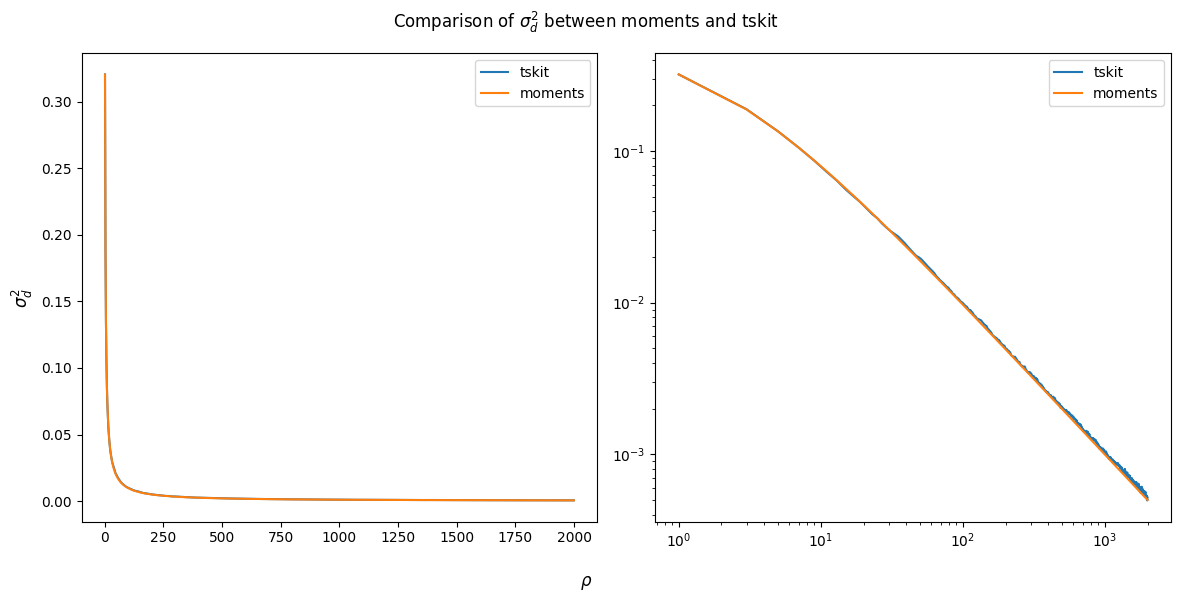

In [9]:
plot_comparison(BINS, moments_D2 / moments_pi2, tskit_D2 / tskit_pi2, rho, r"$\sigma_d^2$", figsize=(12, 6))

### Functionality to Run Moments and Tskit under 2-population demographies

We generate demographies with demes, sampling populations A and B at time 0

In [10]:
def gather_moments_data_demog(rho, theta, bins, demog):
    edges_result = moments.Demes.LD(
        demog,
        sampled_demes=["A", "B"],
        sample_times=[0, 0],
        rho=rho * bins,
        theta=theta,
    )
    mids_result = moments.Demes.LD(
        DEMOG,
        sampled_demes=["A", "B"],
        sample_times=[0, 0],
        rho=rho * midpoint(bins),
        theta=theta,
    )

    mids_ld_stats = np.vstack(mids_result[:-1])
    mids_D2_cross = mids_ld_stats[:, mids_result.names()[0].index('DD_0_1')]
    mids_pi2_1 = mids_ld_stats[:, mids_result.names()[0].index('pi2_0_0_0_0')]
    mids_pi2_2 = mids_ld_stats[:, mids_result.names()[0].index('pi2_1_1_1_1')]
    edges_ld_stats = np.vstack(edges_result[:-1])
    edges_D2_cross = edges_ld_stats[:, edges_result.names()[0].index('DD_0_1')]
    edges_pi2_1 = edges_ld_stats[:, edges_result.names()[0].index('pi2_0_0_0_0')]
    edges_pi2_2 = edges_ld_stats[:, edges_result.names()[0].index('pi2_1_1_1_1')]

    D2 = simpson(edges_D2_cross, mids_D2_cross)
    pi2 = simpson(np.sqrt(edges_pi2_1) * np.sqrt(edges_pi2_2), np.sqrt(mids_pi2_1) * np.sqrt(mids_pi2_2))

    return D2, pi2

In [11]:
def gather_tskit_data_demog(Ne, r, mu, L, bins, max_dist, chunk_size, demog, seed):
    ts = msprime.sim_ancestry(
        samples=[
            msprime.SampleSet(40, population="A"),
            msprime.SampleSet(40, population="B"),
        ],
        sequence_length=L,
        recombination_rate=r,
        demography=msprime.Demography.from_demes(demog),
        random_seed=seed,
    )
    ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)

    decay_D2_cross = ld_decay_two_way(
        ts,
        max_dist=max_dist,
        chunk_size=chunk_size,
        n_threads=15,
        bins=BINS,
        stat="D2_unbiased",
        sample_sets=[ts.samples(population=1), ts.samples(population=2)],
    )
    decay_pi2_1 = ld_decay(
        ts,
        max_dist=max_dist,
        chunk_size=chunk_size,
        n_threads=15,
        bins=BINS,
        stat="pi2_unbiased",
        sample_sets=[ts.samples(population=1)],
    )
    decay_pi2_2 = ld_decay(
        ts,
        max_dist=max_dist,
        chunk_size=chunk_size,
        n_threads=15,
        bins=BINS,
        stat="pi2_unbiased",
        sample_sets=[ts.samples(population=2)],
    )
    return decay_D2_cross, np.sqrt(decay_pi2_1) * np.sqrt(decay_pi2_2)

In [12]:
def gather_and_average(func, seeds, *args, **kwargs):
    """
    Function for running many replicates with different seeds, averaging the final result
    and returning the same data shape that the original functions return
    """
    results = []
    for i, seed in enumerate(seeds):
        kwargs['seed'] = seed
        n_digits = int(np.log10(len(seeds))) + 1
        print(f"Processing seed\t{seed}\t({str(i + 1).zfill(n_digits)}/{len(seeds)})")
        results.append(func(*args, **kwargs))
    assert len({len(r) for r in results}) == 1, 'results of differing lengths'
    assert len({len(a) for r in results for a in r}) == 1, 'results of differing lengths'
    num_returned = len(results[0])
    num_elems = len(results[0][0])
    results = np.vstack(results).reshape(len(results), num_returned, num_elems)
    results = results.mean(0)
    return tuple(results[i] for i in range(num_returned))

### Comparisons of LD decay under 2-population demographies

Here, we examine the behavior of LD decay for sites, using a simple 2-population demography. We sample each population at time 0

<Axes: ylabel='time ago (generations)'>

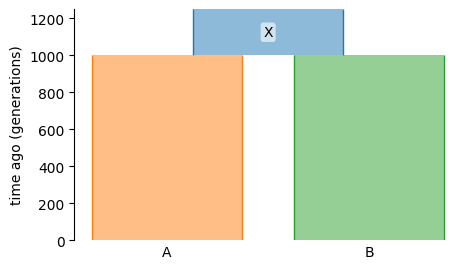

In [13]:
DEMOG = demes.load(
    io.StringIO(
        """
time_units: generations
defaults:
  epoch:
    start_size: 5000
demes:
  - name: X
    epochs:
      - end_time: 1000
  - name: A
    ancestors: [X]
  - name: B
    ancestors: [X]
"""
    )
)
plt.subplots(figsize=(5, 3))
demesdraw.tubes(DEMOG, ax=plt.gca())

In [14]:
rng = np.random.RandomState(SEED)
MAX_DIST = 10_000
CHUNK_SIZE = 100
BINS = np.arange(0, 10_000 + 1, step=CHUNK_SIZE)
moments_D2_2pop, moments_pi2_2pop = gather_moments_data_demog(rho, theta, BINS, DEMOG)
tskit_D2_2pop, tskit_pi2_2pop = gather_and_average(gather_tskit_data_demog, rng.randint(0, 2**31, 40), Ne=Ne, r=r, mu=mu, L=100_000, bins=BINS, max_dist=MAX_DIST, chunk_size=CHUNK_SIZE, demog=DEMOG)

Processing seed	74293843	(01/40)
Processing seed	726266598	(02/40)
Processing seed	1919689768	(03/40)
Processing seed	794519497	(04/40)
Processing seed	1140140982	(05/40)
Processing seed	1209804264	(06/40)
Processing seed	1212880927	(07/40)
Processing seed	317434093	(08/40)
Processing seed	949382604	(09/40)
Processing seed	1898004827	(10/40)
Processing seed	799817767	(11/40)
Processing seed	790253146	(12/40)
Processing seed	717857433	(13/40)
Processing seed	428724147	(14/40)
Processing seed	1685527558	(15/40)
Processing seed	943400827	(16/40)
Processing seed	507030957	(17/40)
Processing seed	1431680524	(18/40)
Processing seed	1769226289	(19/40)
Processing seed	1832943298	(20/40)
Processing seed	10586571	(21/40)
Processing seed	1093382101	(22/40)
Processing seed	1649405637	(23/40)
Processing seed	2134021312	(24/40)
Processing seed	1653337100	(25/40)
Processing seed	356885	(26/40)
Processing seed	1290249776	(27/40)
Processing seed	2044210473	(28/40)
Processing seed	384751183	(29/40)
Proc

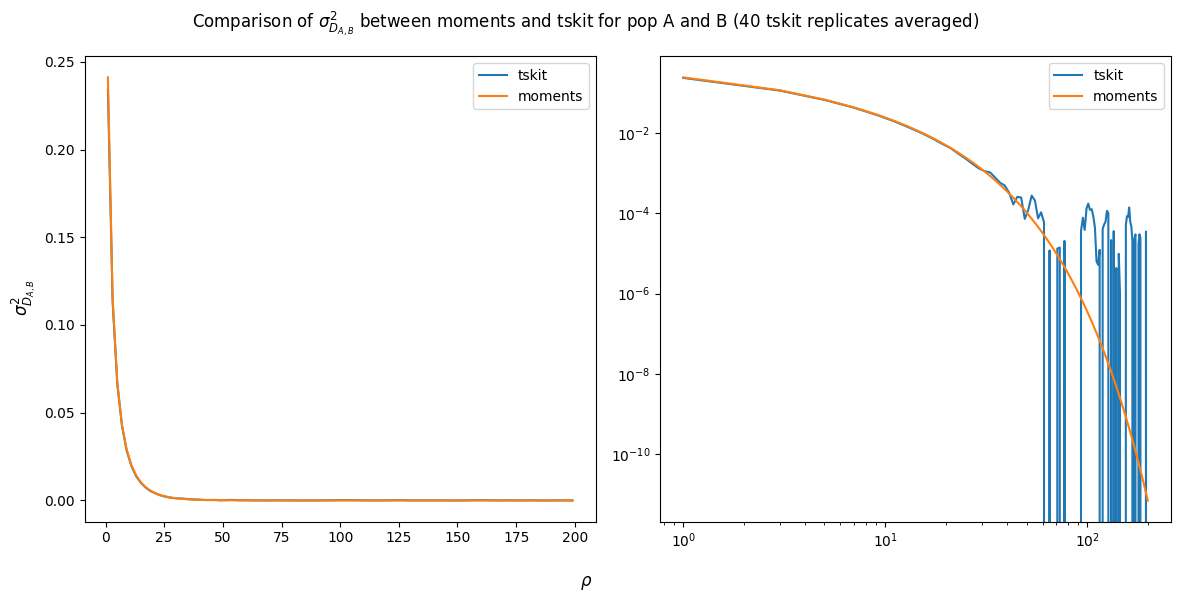

In [15]:
plot_comparison(BINS, moments_D2_2pop / moments_pi2_2pop, tskit_D2_2pop / tskit_pi2_2pop, rho, r"$\sigma_{D_{A,B}}^2$", titleadd="for pop A and B (40 tskit replicates averaged)", figsize=(12, 6))

In [16]:
MAX_DIST = 10_000
CHUNK_SIZE = 100
BINS = np.arange(0, MAX_DIST + 1, step=CHUNK_SIZE)
moments_D2_2pop_1, moments_pi2_2pop_1 = gather_moments_data_demog(rho, theta, BINS, DEMOG)
tskit_D2_2pop_1, tskit_pi2_2pop_1 = gather_tskit_data_demog(Ne=Ne, r=r, mu=mu, L=100_000, bins=BINS, max_dist=MAX_DIST, chunk_size=CHUNK_SIZE, demog=DEMOG, seed=SEED)

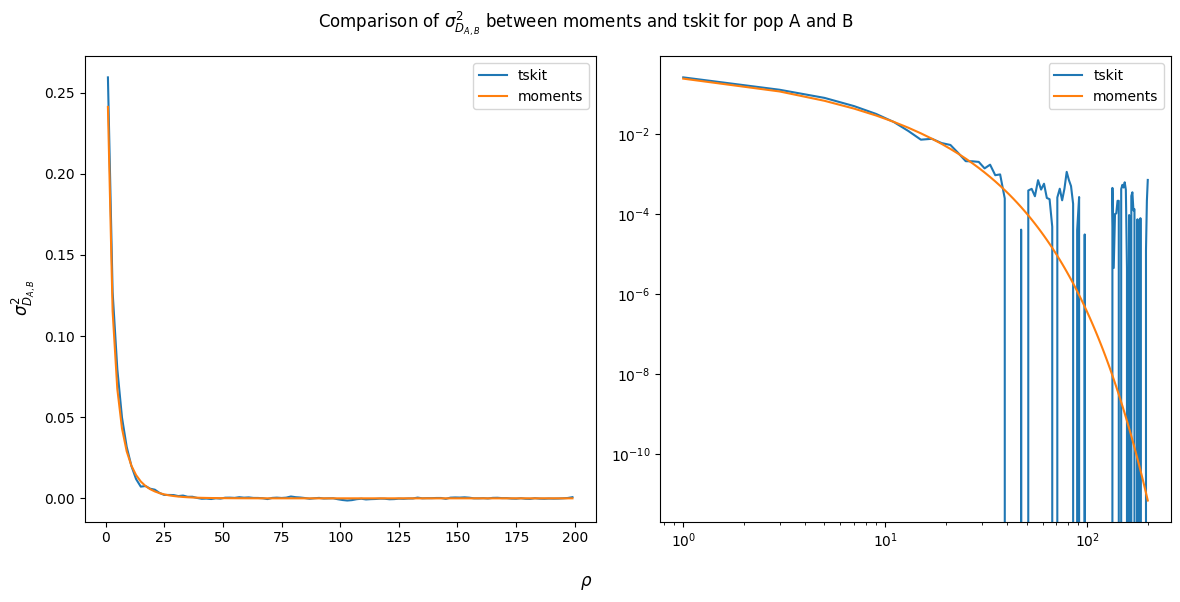

In [17]:
plot_comparison(BINS, moments_D2_2pop_1 / moments_pi2_2pop_1, tskit_D2_2pop_1 / tskit_pi2_2pop_1, rho, r"$\sigma_{D_{A,B}}^2$", titleadd="for pop A and B", figsize=(12, 6))

In [18]:
BINS = np.logspace(1, 4, num=101)
MAX_DIST = 10**4
CHUNK_SIZE = 100
moments_D2_2pop_1_log, moments_pi2_2pop_1_log = gather_moments_data_demog(rho, theta, BINS, DEMOG)
tskit_D2_2pop_1_log, tskit_pi2_2pop_1_log = gather_tskit_data_demog(Ne=Ne, r=r, mu=mu, L=100_000, bins=BINS, max_dist=MAX_DIST, chunk_size=CHUNK_SIZE, demog=DEMOG, seed=SEED)

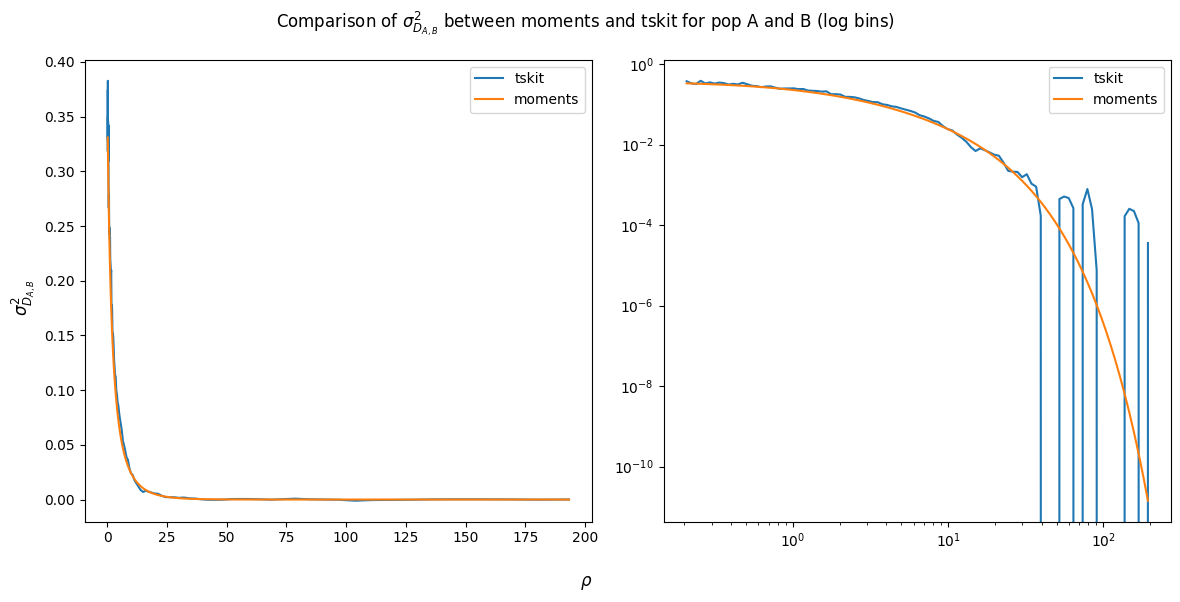

In [19]:
plot_comparison(BINS, moments_D2_2pop_1_log / moments_pi2_2pop_1_log, tskit_D2_2pop_1_log / tskit_pi2_2pop_1_log, rho, r"$\sigma_{D_{A,B}}^2$", titleadd="for pop A and B (log bins)", figsize=(12, 6))

In [ ]:
rng = np.random.RandomState(SEED)
BINS = np.logspace(1, 4, num=101)
MAX_DIST = 10**4
CHUNK_SIZE = 100
BINS = np.arange(0, 10_000 + 1, step=CHUNK_SIZE)
moments_D2_2pop_log, moments_pi2_2pop_log = gather_moments_data_demog(rho, theta, BINS, DEMOG)
tskit_D2_2pop_log, tskit_pi2_2pop_log = gather_and_average(gather_tskit_data_demog, rng.randint(0, 2**31, 40), Ne=Ne, r=r, mu=mu, L=100_000, bins=BINS, max_dist=MAX_DIST, chunk_size=CHUNK_SIZE, demog=DEMOG)

Processing seed	74293843	(01/40)
Processing seed	726266598	(02/40)
Processing seed	1919689768	(03/40)
Processing seed	794519497	(04/40)
Processing seed	1140140982	(05/40)
Processing seed	1209804264	(06/40)
Processing seed	1212880927	(07/40)
Processing seed	317434093	(08/40)
Processing seed	949382604	(09/40)
Processing seed	1898004827	(10/40)
Processing seed	799817767	(11/40)
Processing seed	790253146	(12/40)
Processing seed	717857433	(13/40)
Processing seed	428724147	(14/40)
Processing seed	1685527558	(15/40)
Processing seed	943400827	(16/40)
Processing seed	507030957	(17/40)
Processing seed	1431680524	(18/40)
Processing seed	1769226289	(19/40)
Processing seed	1832943298	(20/40)
Processing seed	10586571	(21/40)
Processing seed	1093382101	(22/40)
Processing seed	1649405637	(23/40)
Processing seed	2134021312	(24/40)
Processing seed	1653337100	(25/40)
Processing seed	356885	(26/40)
Processing seed	1290249776	(27/40)
Processing seed	2044210473	(28/40)
Processing seed	384751183	(29/40)
Proc

In [ ]:
plot_comparison(BINS, moments_D2_2pop_log / moments_pi2_2pop_log, tskit_D2_2pop_log / tskit_pi2_2pop_log, rho, r"$\sigma_{D_{A,B}}^2$", titleadd="for pop A and B (log bins -- 40 replicates)", figsize=(12, 6))

TODO: investigate log bins and chunk size!!!!!